# 01_Data_Preprocessing.ipynb

## 1. Environment Setup & Imports

In [1]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# utilities
import re
from joblib import dump

# download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# set styles
sns.set(style="whitegrid")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Load Raw Data

In [2]:
import pandas as pd
import re

# 0. Load the single uploaded file and assign unique IDs
df = pd.read_excel('FeedbacksDetails.xlsx', header=0, dtype=str)

# Insert a numeric ID column
df.insert(0, 'id', range(1, len(df) + 1))

# 1. Drop completely blank rows
df.dropna(how='all', inplace=True)

# 2. Drop any rows that exactly repeat the header labels
orig_cols = df.columns.tolist()
mask_header_repeat = df.apply(
    lambda row: all(str(row[col]).strip() == str(col).strip() for col in orig_cols),
    axis=1
)
df = df.loc[~mask_header_repeat].reset_index(drop=True)

# 3. Drop empty “Unnamed:” columns (if any)
unnamed = [c for c in df.columns if c.lower().startswith('unnamed')]
df.drop(columns=unnamed, inplace=True)

# 4. Clean and normalize column names, ensuring uniqueness
def clean_header(cols):
    cleaned = []
    for c in cols:
        c0 = str(c).strip().lower()
        c0 = re.sub(r'[^\w\s]', '_', c0)
        c0 = re.sub(r'\s+', '_', c0)
        cleaned.append(c0)
    # make unique
    seen = {}
    unique = []
    for name in cleaned:
        if name in seen:
            seen[name] += 1
            unique.append(f"{name}_{seen[name]}")
        else:
            seen[name] = 0
            unique.append(name)
    return unique

df.columns = clean_header(df.columns)

# 5. Save the cleaned single‐file DataFrame
df.to_excel('preprocessed_feedbacks.xlsx', index=False)

print("Final columns:", df.columns.tolist())
print("Sample data:")
print(df.head())


Final columns: ['id', 'yearcode', 'are_you_given_adequate_amount_of_work', 'what_do_you_think_about_the_work_environment', 'are_the_employees_of_the_organization_friendly_and_supportive', 'is_the_management_of_the_organization_supportive', 'does_the_organization_pay_you_an_allowance', 'do_you_have_any_problem_concerns_regarding_the_industrial_training_program', 'overall_comment_about_the_industrial_training', 'what_is_your_level_of_satisfaction_about_your_internship__a_high__b_average__c_low', 'do_you_recommend_your_training_place_a__yes___b__no']
Sample data:
   id yearcode             are_you_given_adequate_amount_of_work  \
0   1   202110   Yes                                               
1   2   202110   Yes                                               
2   3   202110   Yes                                               
3   4   202110   Yes                                               
4   5   202110   yes                                               

        what_do_you_thin

## 4. Missing-Value & Irrelevant Column Handling


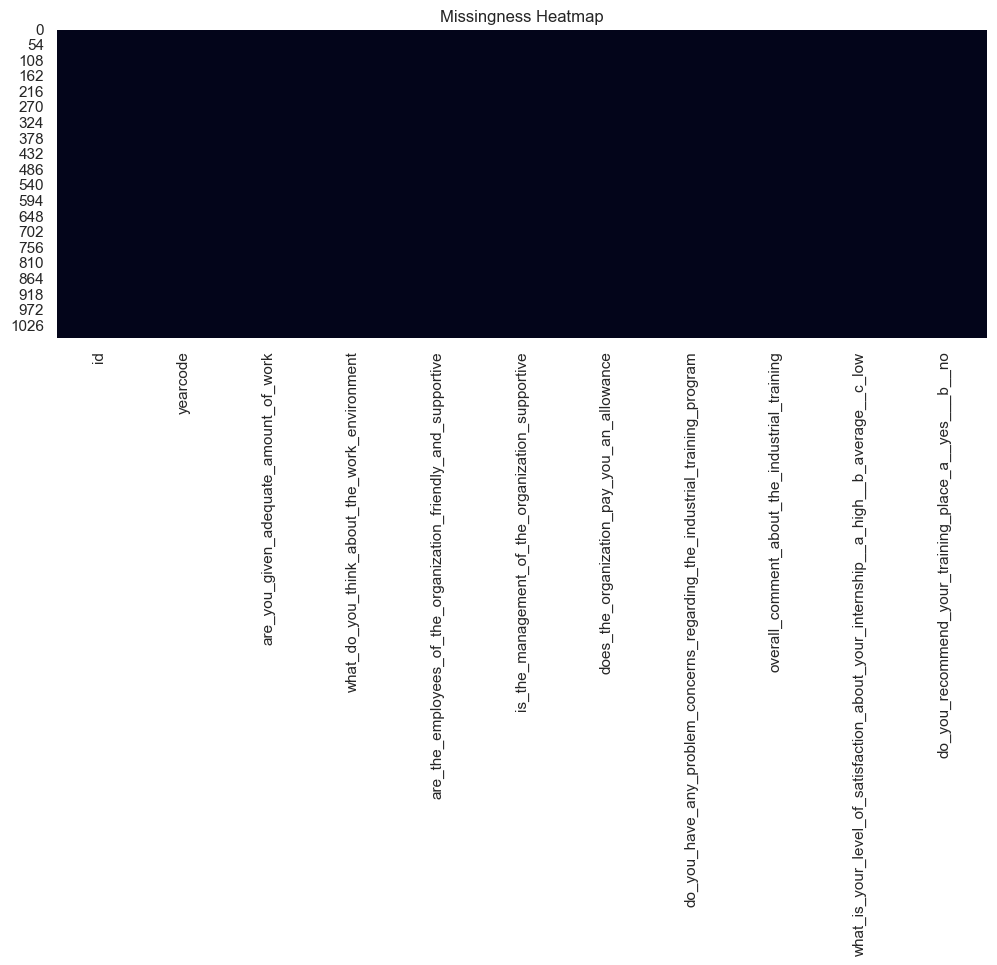

Dropping columns with >50% missing: []
Dropping constant columns: []
Dropping irrelevant columns: ['id']
Remaining columns after cleanup:
['yearcode', 'are_you_given_adequate_amount_of_work', 'what_do_you_think_about_the_work_environment', 'are_the_employees_of_the_organization_friendly_and_supportive', 'is_the_management_of_the_organization_supportive', 'does_the_organization_pay_you_an_allowance', 'do_you_have_any_problem_concerns_regarding_the_industrial_training_program', 'overall_comment_about_the_industrial_training', 'what_is_your_level_of_satisfaction_about_your_internship__a_high__b_average__c_low', 'do_you_recommend_your_training_place_a__yes___b__no']
Cleaned data saved to feedbacks_cleaned_missing_irrelevant.xlsx


In [3]:
# 4. Missing-Value & Irrelevant Column Handling (with save)

import seaborn as sns
import matplotlib.pyplot as plt

# 4.1 Visualize missingness (optional)
plt.figure(figsize=(12, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missingness Heatmap')
plt.show()

# 4.2 Drop columns with >50% missing values
threshold = 0.5
cols_to_drop = [col for col in df.columns if df[col].isna().mean() > threshold]
print(f"Dropping columns with >50% missing: {cols_to_drop}")
df.drop(columns=cols_to_drop, inplace=True)

# 4.3 Drop columns with only one unique non-null value (constants)
const_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 1]
print(f"Dropping constant columns: {const_cols}")
df.drop(columns=const_cols, inplace=True)

# 4.4 Drop identifier or metadata columns
irrelevant = [col for col in df.columns if 'id' in col.lower()
              or 'timestamp' in col.lower() or 'email' in col.lower()]
print(f"Dropping irrelevant columns: {irrelevant}")
df.drop(columns=irrelevant, inplace=True)

# 4.5 Reset index
df.reset_index(drop=True, inplace=True)

# 4.6 Inspect remaining columns
print("Remaining columns after cleanup:")
print(df.columns.tolist())

# 4.7 Save cleaned DataFrame to Excel
output_path = 'feedbacks_cleaned_missing_irrelevant.xlsx'
df.to_excel(output_path, index=False)
print(f"Cleaned data saved to {output_path}")


## 5. Basic Text Cleaning Function


In [4]:
# 5. Basic Text Cleaning Function and Save

import re


def clean_text(text: str) -> str:
    """
    Perform basic text cleaning:
      1. Lowercase
      2. Remove URLs
      3. Remove non-alphanumeric characters
      4. Collapse multiple spaces
      5. Strip leading/trailing whitespace
    """
    if pd.isna(text):
        return ""
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # 3. Remove non-alphanumeric characters (keep spaces)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # 4. Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # 5. Strip
    return text.strip()


# Apply clean_text to each free-text column
text_cols = [col for col in df.columns if df[col].dtype == object]
for col in text_cols:
    clean_col = f"{col}_clean"
    df[clean_col] = df[col].apply(clean_text)

# Inspect a few rows
print(df[text_cols + [f"{c}_clean" for c in text_cols]].head())

# Save the DataFrame with cleaned text to Excel
output_path = 'feedbacks_after_text_cleaning.xlsx'
df.to_excel(output_path, index=False)
print(f"Data with cleaned text saved to {output_path}")


  yearcode             are_you_given_adequate_amount_of_work  \
0   202110   Yes                                               
1   202110   Yes                                               
2   202110   Yes                                               
3   202110   Yes                                               
4   202110   yes                                               

        what_do_you_think_about_the_work_environment  \
0   It is a good working environment for who is s...   
1   Friendly staff and they help us whenever requ...   
2   It is friendly and supportive                ...   
3   Friendly and helpful                         ...   
4   friendly, highly experienced  and knowledgeab...   

  are_the_employees_of_the_organization_friendly_and_supportive  \
0   Yes of course. They are very supportive and a...              
1   Yes                                          ...              
2   Yes                                          ...              
3   Yes   

## 6. NLP Preprocessing Pipeline


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


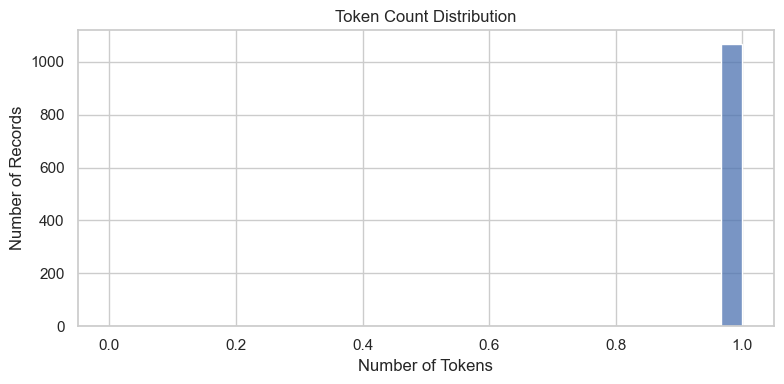

Preprocessed data saved to cleaned_feedback_preprocessed.xlsx
Text preprocessing functions saved.


In [5]:
# 6. NLP Preprocessing Pipeline (no POS tagging, default noun lemmatization)

import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# 6.1 Ensure WordNet data is available for lemmatizer
nltk.download('wordnet')

# 6.2 Initialize stopwords, lemmatizer, and tokenizer
stop_words = set(stopwords.words('english'))
stop_words.update(['internship', 'experience', 'expectation', 'company'])
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')  # splits on non-alphanumeric


# 6.3 Simplified preprocessing function (default to noun form)
def preprocess_text(text):
    cleaned = clean_text(text)
    tokens = tokenizer.tokenize(cleaned.lower())
    result = []
    for token in tokens:
        if token not in stop_words:
            lemma = lemmatizer.lemmatize(token)  # defaults to noun
            result.append(lemma)
    return result


# 6.4 Load the file with basic-cleaned text
df = pd.read_excel('feedbacks_after_text_cleaning.xlsx', dtype=str)

# 6.5 Identify clean-text columns
text_cols = [col for col in df.columns if col.endswith('_clean')]

# 6.6 Apply preprocessing to each clean-text column
for col in text_cols:
    tok_col = col.replace('_clean', '_clean_tokens')
    df[tok_col] = df[col].apply(preprocess_text)

# 6.7 Visualize token count distribution for the first column
first_tok = text_cols[0].replace('_clean', '_clean_tokens')
df['token_count'] = df[first_tok].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(df['token_count'], bins=30, kde=False)
plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

# 6.8 Save processed DataFrame
output_path = 'cleaned_feedback_preprocessed.xlsx'
df.to_excel(output_path, index=False)
print(f"Preprocessed data saved to {output_path}")

# 6.9 Save helper functions
dump(clean_text, 'models/clean_text.fn')
dump(preprocess_text, 'models/preprocess_text.fn')
print("Text preprocessing functions saved.")


## 7. Save Preprocessed Data & Text Processor
